### I. Classification des Champignons avec Pyspark et MLlib

In [108]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

#### Initialisation de SparkContext et SparkSession

In [110]:
sc = SparkContext()

spark = SparkSession.builder.appName("MushroomClassification").getOrCreate()

### Schema du DataFrame

In [111]:
data_mushrooms = spark.read.format('csv').\
option('inferSchema','true').\
option('header', 'true').\
option('path', 'mushrooms.csv').\
load()

In [75]:
data_mushrooms.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

In [94]:
type(data_mushrooms)

pyspark.sql.dataframe.DataFrame

### Preprocessing des features 

In [112]:
in_cols = data_mushrooms.schema.names[1:]

str_indexers = [StringIndexer(inputCol=c, outputCol=c+'_idx') for c in in_cols]
# a list of StringIndexer objects to convert strings to integer indices
# each indexer is responsible for converting one feature column

onehot_encoders = [OneHotEncoder(dropLast=False, inputCol=c+'_idx', outputCol=c+'_onehot') for c in in_cols]
# a list of OneHotEncoder objects to convert integer indices of cat levels to one-hot encoded columns
# each encoder is responsible fore encoding one feature column

onehot_cols = [c+'_onehot' for c in in_cols]

feat_assembler = VectorAssembler(inputCols=onehot_cols, outputCol='features')
# a VectorAssembler object that assembles all the one-hot encoded columns into one column,
# each row of which is a vector of all the numbers in those one-hot columns.
# e.g.
# +-----+-----+-----+-----+---------------------+
# |cat_0|cat_1|cat_2|cat_3|             features|
# +-----+-----+-----+-----+---------------------+
# |    1|    0|    0|    0| [1.0, 0.0, 0.0, 0.0]|
# |    0|    1|    0|    0| [0.0, 1.0, 0.0, 0.0]|
# |    0|    0|    0|    1| [0.0, 0.0, 0.0, 1.0]|
# +-----+-----+-----+-----+---------------------+

label_indexer = StringIndexer(inputCol = data_mushrooms.schema.names[0], outputCol='poisonous')
# a StringIndexer object that converts <class> column's {e, p} to {0, 1}
# Because there are more 'e' class in the sample, it will be encoded 0, since StringIndexer gives more frequent levels a lower index
# Run `mushrooms.groupby('class').count().show()` in pyspark shell to see counts of each class

pipeline = Pipeline(stages=str_indexers+onehot_encoders+[feat_assembler, label_indexer])
# A Pipeline object that combines all the transformations we defined above.

# Use the pipeline object to transform our dataframe
data_mushrooms_trans = pipeline \
                    .fit(data_mushrooms) \
                    .transform(data_mushrooms) \
                    .cache()

In [113]:
 data_mushrooms.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    e| 4208|
|    p| 3916|
+-----+-----+



### Split du dataset en train et test

In [114]:
mushrooms_train, mushrooms_val = data_mushrooms_trans.randomSplit([0.7, 0.3], seed=2017)

### Train model with Random forest

In [116]:
model = RandomForestClassifier(labelCol='poisonous', featuresCol='features', numTrees=200) \
        .fit(mushrooms_train)

### Predict and evaluate a model 

In [117]:
pred = model.transform(mushrooms_val)

results = pred.select(['probability', 'prediction', 'poisonous'])

results_collect = results.collect()
# After .collect(), `results_collect` become a list of Row objects

correct = results.withColumn('correct', (results.prediction==results.poisonous).cast('integer')).select('correct')

accuracy = correct.agg({'correct':'mean'}).collect()[0][0]

print('Test accuracy:', accuracy)

Test accuracy: 0.988529291274068


###### Some intermediate results

In [118]:
results.show(5)

+--------------------+----------+---------+
|         probability|prediction|poisonous|
+--------------------+----------+---------+
|[0.95982912711196...|       0.0|      0.0|
|[0.96550770066792...|       0.0|      0.0|
|[0.96195439264680...|       0.0|      0.0|
|[0.94786380659111...|       0.0|      0.0|
|[0.95354238014707...|       0.0|      0.0|
+--------------------+----------+---------+
only showing top 5 rows



In [121]:
correct.show(5)

+-------+
|correct|
+-------+
|      1|
|      1|
|      1|
|      1|
|      1|
+-------+
only showing top 5 rows



In [122]:
accuracy

0.988529291274068

### II. Classification des Champignons

##### 1. Analyse Exploratoire de Données(EDA)

##### 1.1 Description du dataset:

 * classes: edible=e, poisonous=p
 * cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
 * cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
 * cap-color:  * brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
 * bruises: bruises=t,no=f
 * odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
 * gill-attachment: attached=a,descending=d,free=f,notched=n
 * gill-spacing: close=c,crowded=w,distant=d
 * gill-size: broad=b,narrow=n
 * gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,  * green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
 * stalk-shape: enlarging=e,tapering=t
 * stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
 * stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
 * stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
 * stalk-color-above-ring:  * brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
 * stalk-color-below-ring:  * brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
 * veil-type: partial=p,universal=u
 * veil-color: brown=n,orange=o,white=w,yellow=y
 * ring-number: none=n,one=o,two=t
 * ring-type:  * cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
 * spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
 * population:  * abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
 * habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d


##### 1.2 Importation des librairies utilisées

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
pd.set_option('display.max_columns', None)

##### 1.3 Exploration du dataset
##### 1.3.1 Importation

In [2]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


##### 1.3.2 EDA du datastet

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


##### 1.4 Analyse et visualisation

In [6]:
class_mapping = {'e': 'edible', 'p': 'poisonous'}
cap_shape_mapping = {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'}
cap_surface_mapping = {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'}
cap_color_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'}
bruises_mapping = {'t': 'bruises', 'f': 'no'}
odor_mapping = {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'}
gill_attachment_mapping = {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'}
gill_spacing_mapping = {'c': 'close', 'w': 'crowded', 'd': 'distant'}
gill_size_mapping = {'b': 'broad', 'n': 'narrow'}
gill_color_mapping = {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'}
stalk_shape_mapping = {'e': 'enlarging', 't': 'tapering'}
stalk_root_mapping = {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'}
stalk_surface_above_ring_mapping = {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'}
stalk_surface_below_ring_mapping = {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'}
stalk_color_above_ring_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'}
stalk_color_below_ring_mapping = {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'}
veil_type_mapping = {'p': 'partial', 'u': 'universal'}
veil_color_mapping = {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'}
ring_number_mapping = {'n': 'none', 'o': 'one', 't': 'two'}
ring_type_mapping = {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'}
spore_print_color_mapping = {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'}
population_mapping = {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'}
habitat_mapping = {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}

attribute_mappings = {
    'class': class_mapping,
    'cap-shape': cap_shape_mapping,
    'cap-surface': cap_surface_mapping,
    'cap-color': cap_color_mapping,
    'bruises': bruises_mapping,
    'odor': odor_mapping,
    'gill-attachment': gill_attachment_mapping,
    'gill-spacing': gill_spacing_mapping,
    'gill-size': gill_size_mapping,
    'gill-color': gill_color_mapping,
    'stalk-shape': stalk_shape_mapping,
    'stalk-root': stalk_root_mapping,
    'stalk-surface-above-ring': stalk_surface_above_ring_mapping,
    'stalk-surface-below-ring': stalk_surface_below_ring_mapping,
    'stalk-color-above-ring': stalk_color_above_ring_mapping,
    'stalk-color-below-ring': stalk_color_below_ring_mapping,
    'veil-type': veil_type_mapping,
    'veil-color': veil_color_mapping,
    'ring-number': ring_number_mapping,
    'ring-type': ring_type_mapping,
    'spore-print-color': spore_print_color_mapping,
    'population': population_mapping,
    'habitat': habitat_mapping,
}

for column, mapping in attribute_mappings.items():
    df[column] = df[column].replace(mapping)

In [103]:
df

,class_poisonous,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,cap-color_cinnamon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,bruises_no,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,gill-attachment_free,gill-spacing_crowded,gill-size_narrow,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,stalk-shape_tapering,stalk-root_club,stalk-root_equal,stalk-root_missing,stalk-root_rooted,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,stalk-color-above-ring_buff,stalk-color-above-ring_cinnamon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_buff,stalk-color-below-ring_cinnamon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_one,ring-number_two,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,population_clustered,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [7]:
df.isna().sum().sum()

0

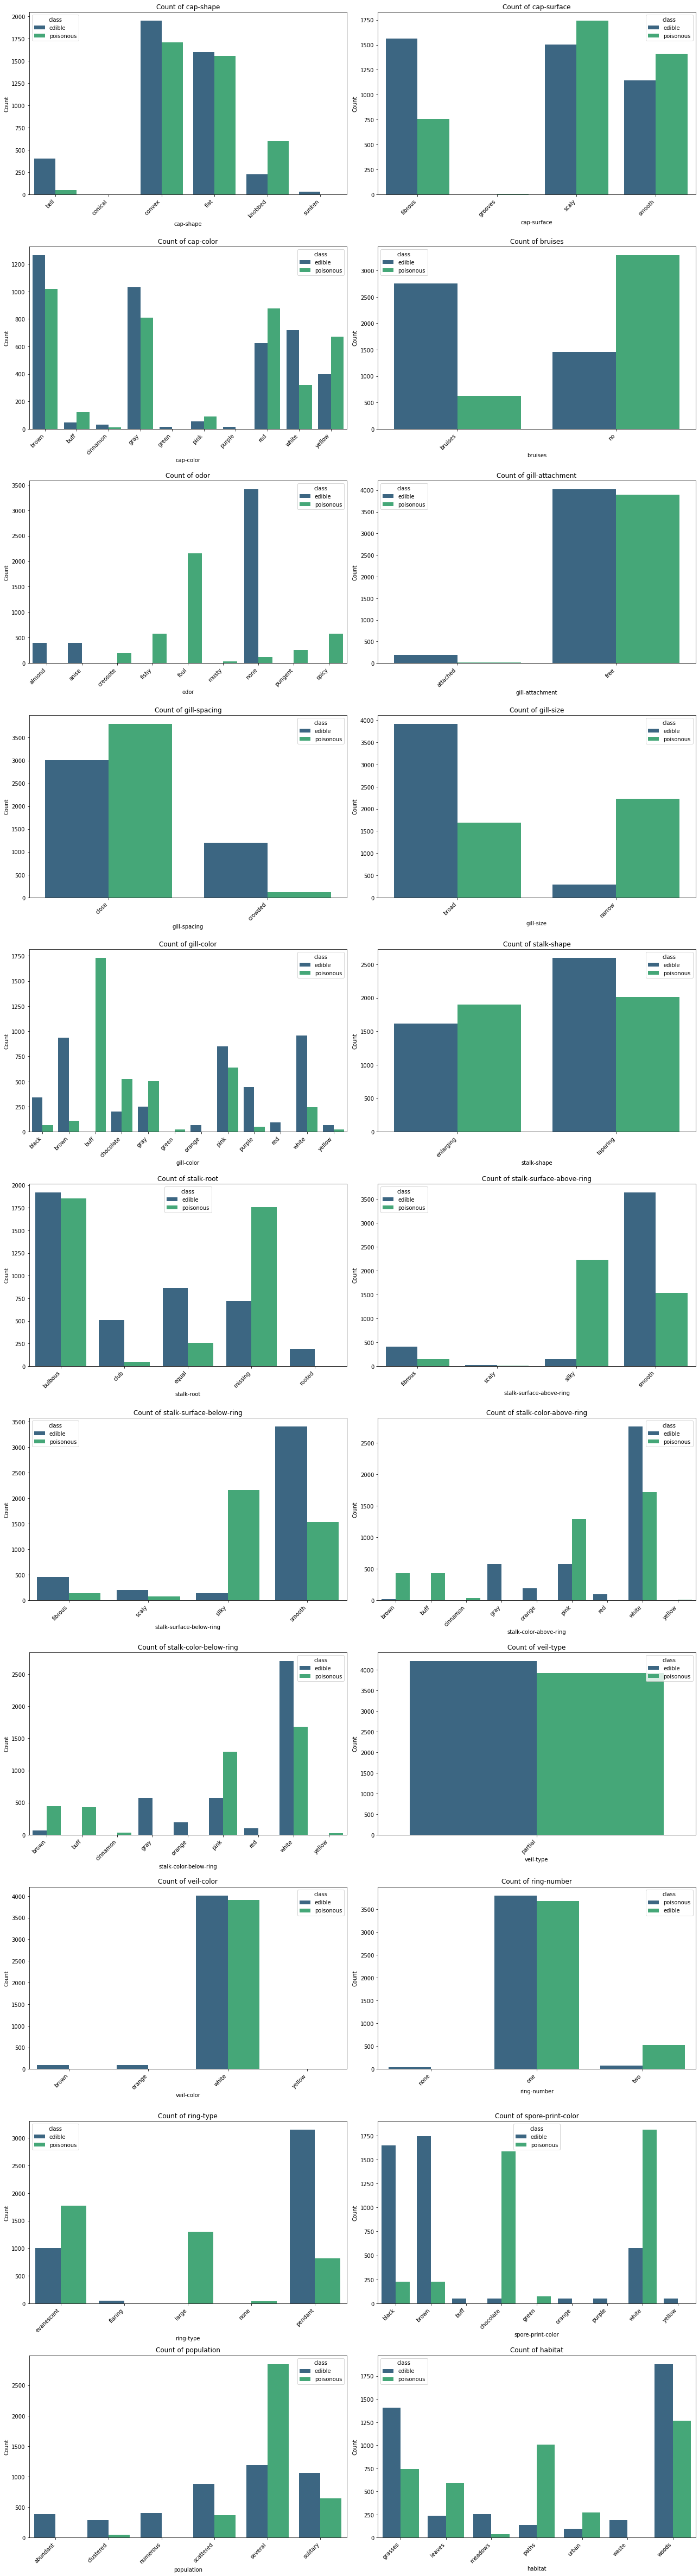

In [8]:
def plot_count(x,ax):
    group = df.groupby([f'{x}','class'])['class'].count().reset_index(name='Count')
    sns.barplot(data=group,x=x,y='Count',hue='class',palette='viridis',ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'Count of {x}')
cols = df.columns.tolist()
fig, axes = plt.subplots(11, 2, figsize=(18, 6 * 11))

for index,column in enumerate(cols[1:]):
    row = index // 2 
    col = index % 2
    ax = axes[row,col]
    plot_count(column, ax)
    
plt.tight_layout()
plt.show()

In [9]:
df.drop('veil-type',axis=1,inplace=True)
df = pd.get_dummies(df,dtype=float,drop_first=True)

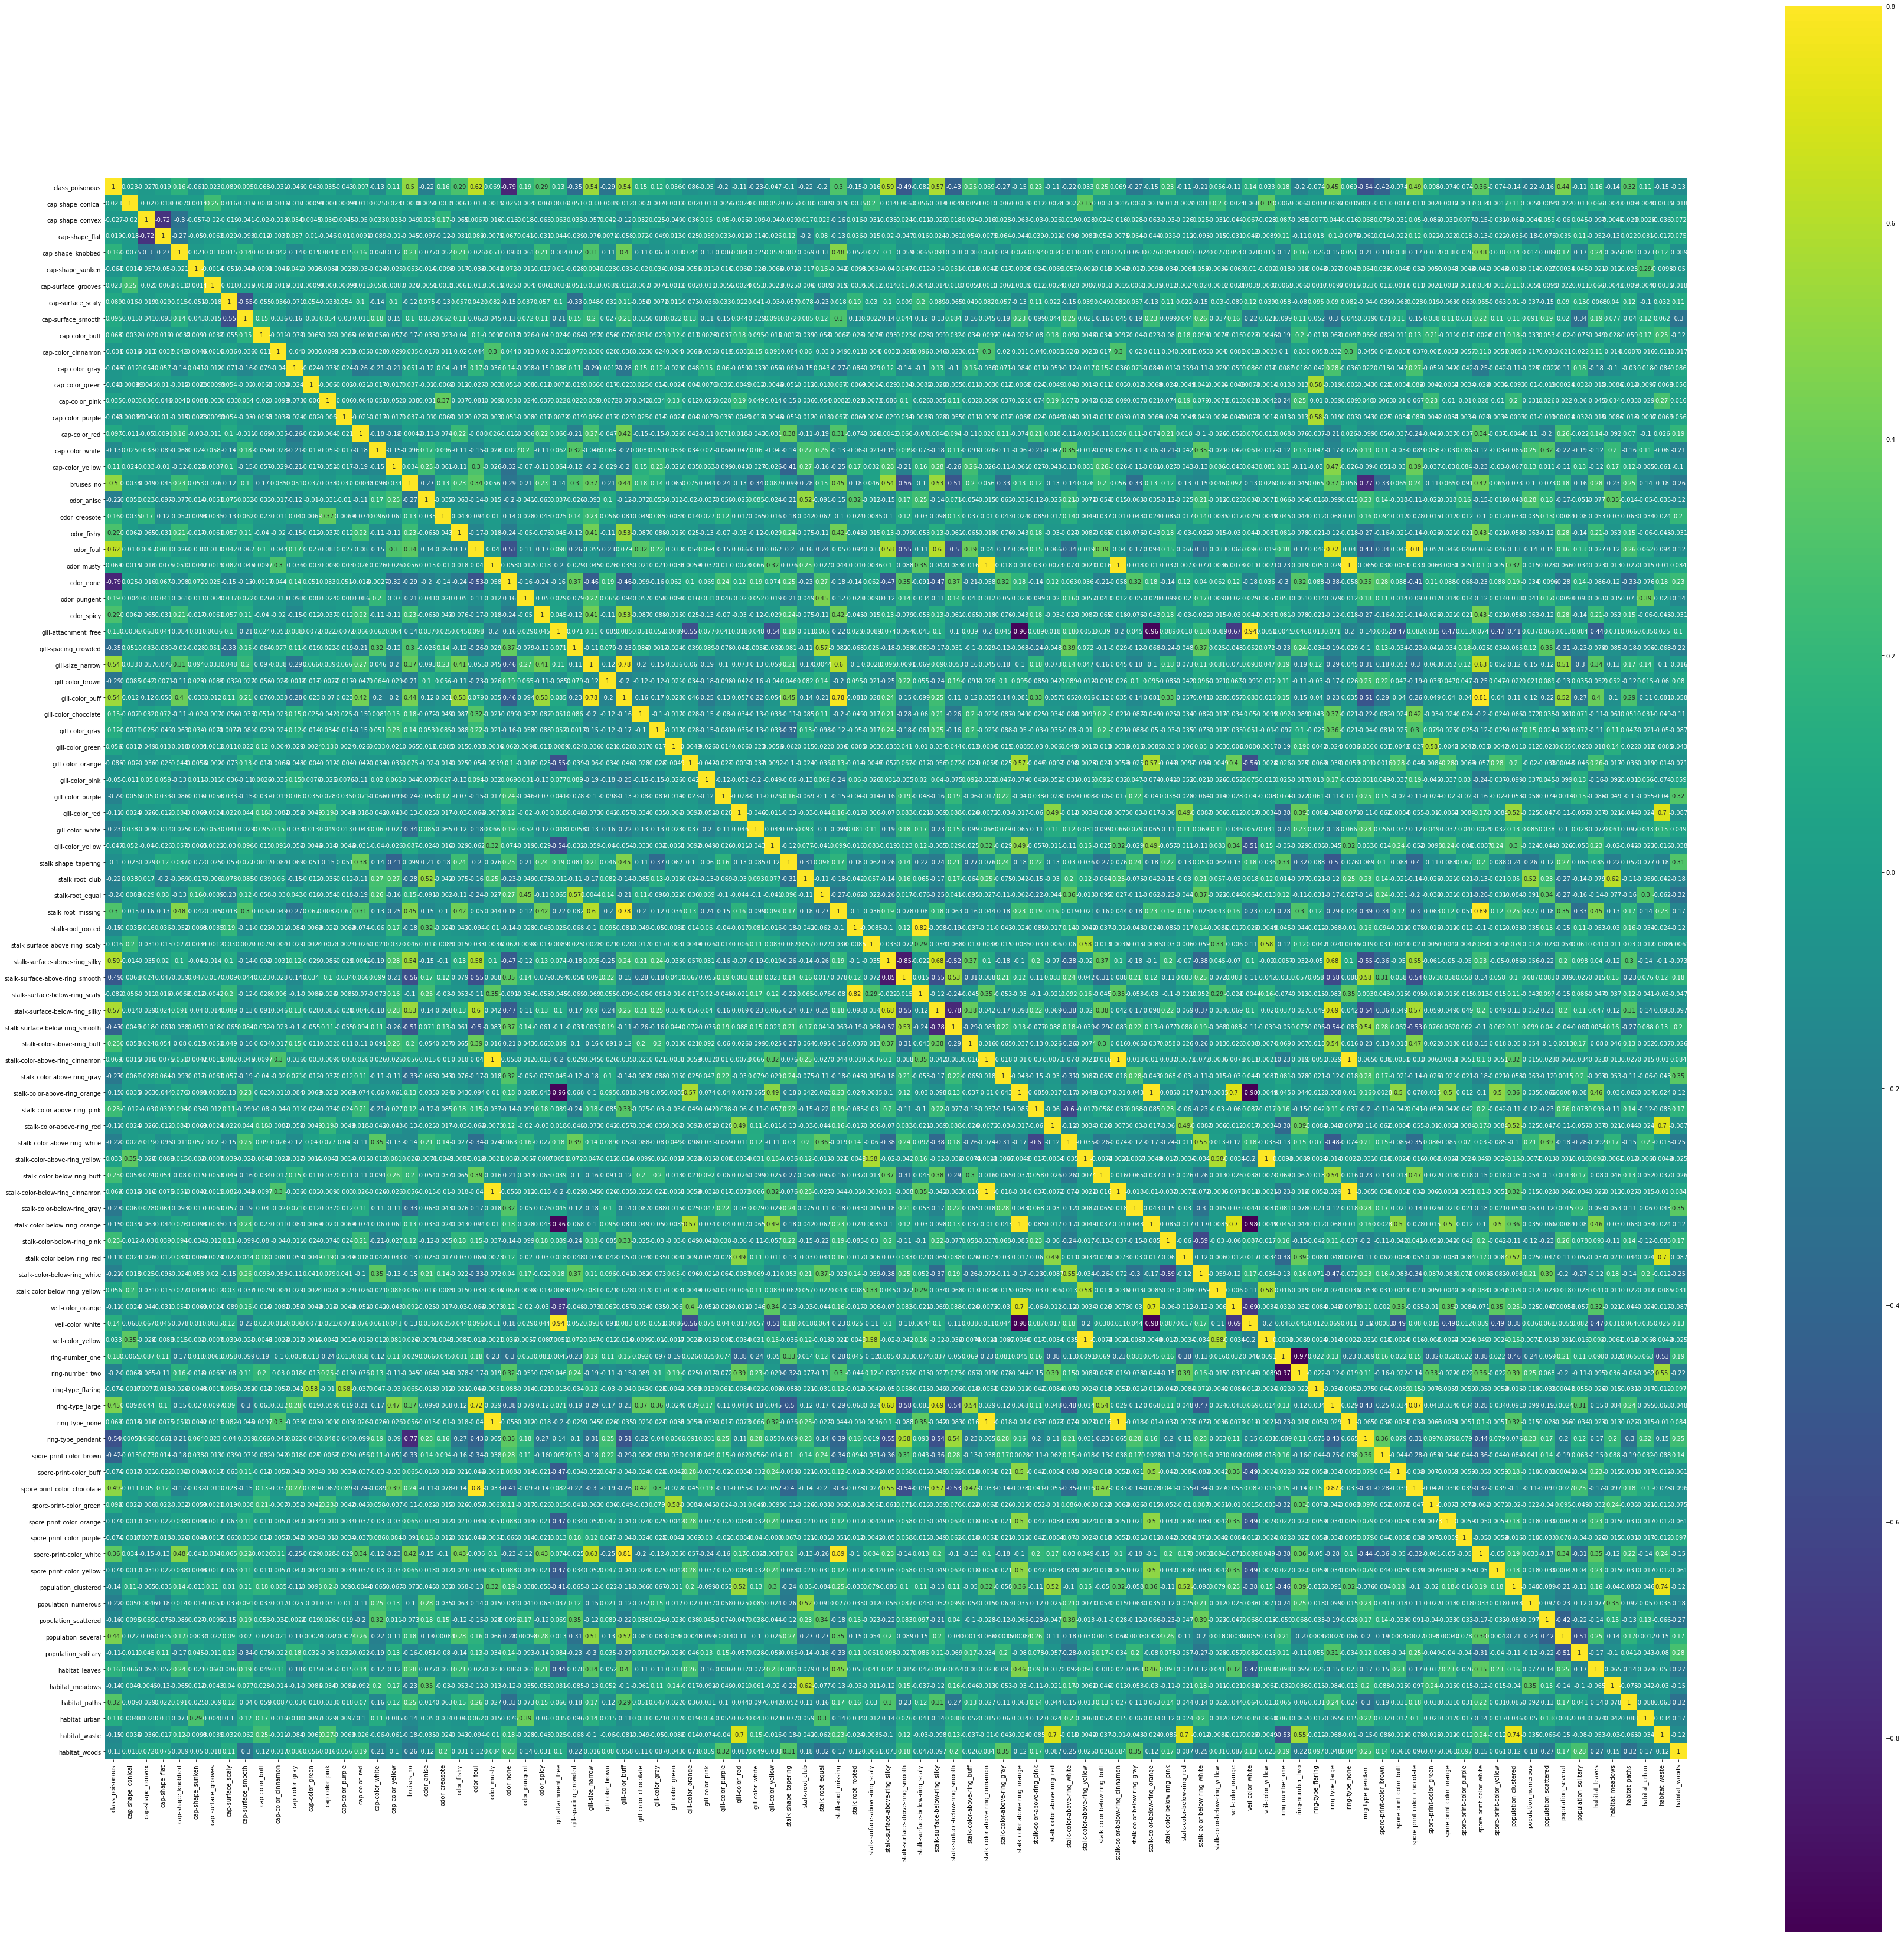

In [10]:
plt.figure(figsize=(60,60))
sns.heatmap(df.corr(),vmax=.8, annot=True,square=True,cmap='viridis');

##### 1.4 Preprocessing du dataset

In [11]:
df.head()

,class_poisonous,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_buff,cap-color_cinnamon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,bruises_no,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,gill-attachment_free,gill-spacing_crowded,gill-size_narrow,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,stalk-shape_tapering,stalk-root_club,stalk-root_equal,stalk-root_missing,stalk-root_rooted,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,stalk-color-above-ring_buff,stalk-color-above-ring_cinnamon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_buff,stalk-color-below-ring_cinnamon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_one,ring-number_two,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,population_clustered,population_numerous,population_scattered,population_several,population_solitary,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
index_to_exclude = df.columns.get_loc('class_poisonous')
X = df.iloc[:, [i for i in range(df.shape[1]) if i != index_to_exclude]].values
y = df.iloc[:,index_to_exclude].values

##### 1.4.1 Split du dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=329) 

In [102]:
y_train

array([0., 1., 0., ..., 1., 0., 1.])

### 2. Modèles

##### 2.1 Logistic Regression

###### Entrainement du modèle

In [14]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

###### Evaluation du modèle

Training Accuracy =  99.97  %
Testing Accuracy =  100.0  %


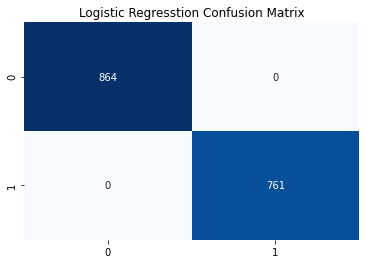

In [15]:
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
lr_train_acc = round(accuracy_score(y_train,lr.predict(X_train))*100,2)
lr_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , lr_train_acc,' %')
print('Testing Accuracy = ' , lr_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Logistic Regresstion Confusion Matrix');

##### 2.2 KNN (K Nearest Neaighbors)

###### Entrainement du modèle

In [16]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

###### Evaluation du modèle

C:\Users\Daou\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Daou\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Daou\anaconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Daou\anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Daou\anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


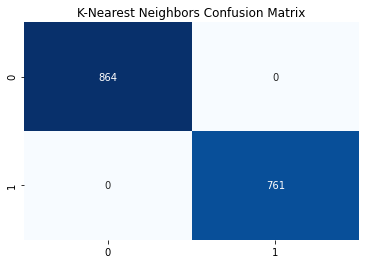

In [17]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
knn_train_acc = round(accuracy_score(y_train,knn.predict(X_train))*100,2)
knn_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , knn_train_acc,' %')
print('Testing Accuracy = ' , knn_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('K-Nearest Neighbors Confusion Matrix');

##### 2.3 Linear Support Vector Machine

###### Entrainement du modèle

In [18]:
svm = SVC(kernel='linear')
svm.fit(X_train,y_train)

SVC(kernel='linear')

###### Evaluation du modèle

Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


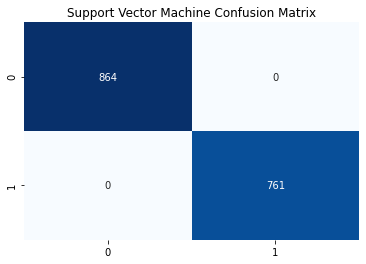

In [19]:
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
svm_train_acc = round(accuracy_score(y_train,svm.predict(X_train))*100,2)
svm_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , svm_train_acc,' %')
print('Testing Accuracy = ' , svm_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Support Vector Machine Confusion Matrix');

##### 2.4 Kernel Support Vector Machine

###### Entrainement du modèle

In [20]:
svm_kernel = SVC(kernel='rbf')
svm_kernel.fit(X_train,y_train)

SVC()

###### Evaluation du modèle

Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


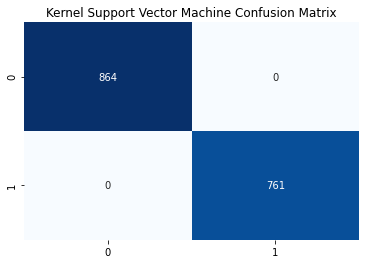

In [21]:
y_pred = svm_kernel.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
svm_k_train_acc = round(accuracy_score(y_train,svm_kernel.predict(X_train))*100,2)
svm_k_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , svm_k_train_acc,' %')
print('Testing Accuracy = ' , svm_k_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Kernel Support Vector Machine Confusion Matrix');

##### 2.5 Naive Bayes 

###### Entrainement du modèle

In [22]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

###### Evaluation du modèle

Training Accuracy =  99.35  %
Testing Accuracy =  99.08  %


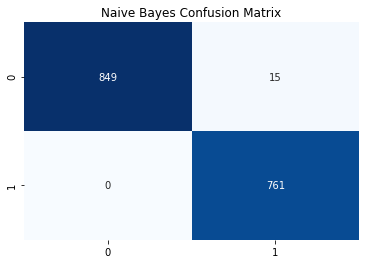

In [23]:
y_pred = nb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
nb_train_acc = round(accuracy_score(y_train,nb.predict(X_train))*100,2)
nb_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , nb_train_acc,' %')
print('Testing Accuracy = ' , nb_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Naive Bayes Confusion Matrix');

#### 2.6 Decision Tree

###### Entrainement du modèle

In [24]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

###### Evaluation du modèle

Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


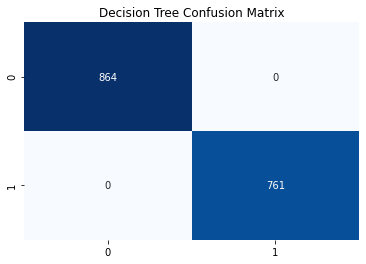

In [25]:
y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tree_train_acc = round(accuracy_score(y_train,tree.predict(X_train))*100,2)
tree_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , tree_train_acc,' %')
print('Testing Accuracy = ' , tree_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Decision Tree Confusion Matrix');

##### 2.7 Random Forest 

###### Entrainement du modèle

In [26]:
rdm_frst = RandomForestClassifier(n_estimators=100)
rdm_frst.fit(X_train,y_train)

RandomForestClassifier()

###### Evaluation du modèle

Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


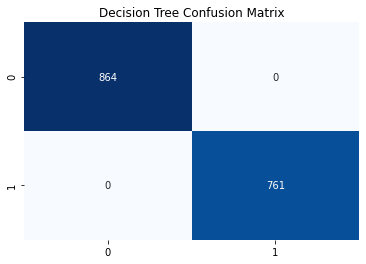

In [27]:
y_pred = rdm_frst.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
rdm_train_acc = round(accuracy_score(y_train,rdm_frst.predict(X_train))*100,2)
rdm_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , rdm_train_acc,' %')
print('Testing Accuracy = ' , rdm_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Decision Tree Confusion Matrix');

##### 2.8 Neural Network

###### Entrainement du modèle

In [36]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
nn_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),   
                metrics=['accuracy'])
history = nn_model.fit(X_train,y_train,epochs=20)

Epoch 1/20
204/204 [==============================] - 1s 3ms/step - loss: 0.0687 - accuracy: 0.9774
Epoch 2/20
204/204 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 3/20
204/204 [==============================] - 1s 3ms/step - loss: 1.8031e-04 - accuracy: 1.0000
Epoch 4/20
204/204 [==============================] - 1s 3ms/step - loss: 6.4098e-05 - accuracy: 1.0000
Epoch 5/20
204/204 [==============================] - 1s 3ms/step - loss: 3.6543e-05 - accuracy: 1.0000
Epoch 6/20
204/204 [==============================] - 1s 3ms/step - loss: 2.3399e-05 - accuracy: 1.0000
Epoch 7/20
204/204 [==============================] - 1s 3ms/step - loss: 1.6454e-05 - accuracy: 1.0000
Epoch 8/20
204/204 [==============================] - 1s 3ms/step - loss: 1.2240e-05 - accuracy: 1.0000
Epoch 9/20
204/204 [==============================] - 1s 3ms/step - loss: 9.3716e-06 - accuracy: 1.0000
Epoch 10/20
204/204 [==============================] - 1s 3ms/step - los

###### Evaluation du modèle

##### 1.Caractéristiques du reseau de neurones

In [29]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 480       
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 546
Trainable params: 546
Non-trainable params: 0
_________________________________________________________________


##### 2.Courbe Loss

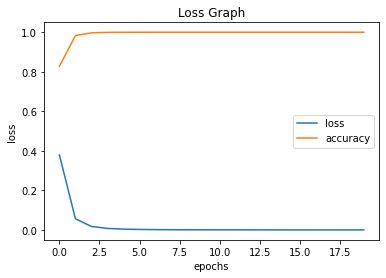

In [30]:
pd.DataFrame(history.history).plot()
plt.title('Loss Graph')
plt.ylabel('loss')
plt.xlabel('epochs');

##### 3.Matrice de Confusion

204/204 [==============================] - 0s 2ms/step
Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


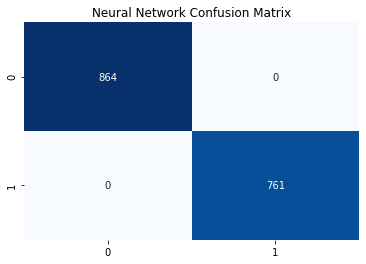

In [31]:
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
nn_train_acc = round(accuracy_score(y_train,np.round(nn_model.predict(X_train)))*100,2)
nn_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , nn_train_acc,' %')
print('Testing Accuracy = ' , nn_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('Neural Network Confusion Matrix');

##### 2.9 XGBoost Classifier

###### Entrainement du modèle

In [32]:
xg = XGBClassifier()
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

###### Evaluation du modèle

Training Accuracy =  100.0  %
Testing Accuracy =  100.0  %


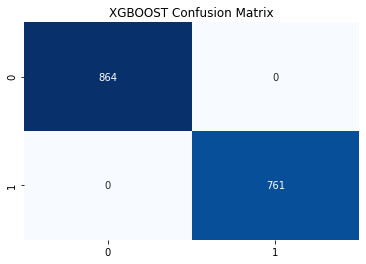

In [33]:
y_pred = xg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
xg_train_acc = round(accuracy_score(y_train,xg.predict(X_train))*100,2)
xg_test_acc = round(accuracy_score(y_test,y_pred)*100,2)
print('Training Accuracy = ' , xg_train_acc,' %')
print('Testing Accuracy = ' , xg_test_acc,' %')
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.title('XGBOOST Confusion Matrix');

### 3. Comparaison des modèles

In [34]:
models = pd.DataFrame({
    'Model': [
        'Logistic Regression','K Nearest Neighbors','Linear Support Vector Machines',
        'Kernel Support Vector Machines', 'Gaussian Naive Bayes','Decision Tree',
        'Random Forest','Neural Network','XGBoost Classifier'
    ],
    'Training Accuracy': [
        lr_train_acc,knn_train_acc,svm_train_acc,svm_k_train_acc,nb_train_acc,tree_train_acc,rdm_train_acc,nn_train_acc,xg_train_acc
    ],
    'Testing Accuracy': [
       lr_test_acc,knn_test_acc,svm_test_acc,svm_k_test_acc,nb_test_acc,tree_test_acc,rdm_test_acc,nn_test_acc,xg_test_acc
    ]
})

In [35]:
models.sort_values(by=['Testing Accuracy','Training Accuracy'], ascending=False).style.background_gradient(
        cmap='coolwarm')

,Model,Training Accuracy,Testing Accuracy
1,K Nearest Neighbors,100.000000,100.000000
2,Linear Support Vector Machines,100.000000,100.000000
3,Kernel Support Vector Machines,100.000000,100.000000
5,Decision Tree,100.000000,100.000000
6,Random Forest,100.000000,100.000000
7,Neural Network,100.000000,100.000000
8,XGBoost Classifier,100.000000,100.000000
0,Logistic Regression,99.970000,100.000000
4,Gaussian Naive Bayes,99.350000,99.080000



documentation:


https://www.youtube.com/watch?v=KPDwnwM1h6E&ab_channel=PythonSamurai